In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# better display of review text in dataframes
pd.set_option('display.max_colwidth', None)

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

In [2]:
import tensorflow as tf

# Prepare data

## Load dataset

In [3]:
import pickle

PICKLE_PATH = "allocine_dataset.pickle"

with open(PICKLE_PATH, 'rb') as reader:
    data = pickle.load(reader)

# Reviews need to be tokenized
train_reviews = np.array(data["train_set"]['review'])
val_reviews = np.array(data["val_set"]['review'])
test_reviews = np.array(data["test_set"]['review'])

train_labels = data["train_set"]['polarity']
val_labels = data["val_set"]['polarity']
test_labels = data["test_set"]['polarity']
class_names = data['class_names']

## Preprocess dataset

### Tokenize

In [4]:
from transformers import CamembertTokenizer

model_name = "jplu/tf-camembert-base"
tokenizer = CamembertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
some_review = train_reviews[0]
some_review

'Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouvement

In [6]:
tokenizer.tokenize(some_review)[:15]

['▁Si',
 '▁vous',
 '▁cherchez',
 '▁du',
 '▁cinéma',
 '▁abruti',
 'ssant',
 '▁à',
 '▁tous',
 '▁les',
 '▁étages',
 ',',
 'n',
 "'",
 'ayant']

In [7]:
tokenizer.encode(some_review)[:15]

[5, 168, 39, 3162, 25, 1545, 29470, 2927, 15, 117, 19, 9339, 7, 255, 11]

In [8]:
tokenizer.decode(tokenizer.encode(some_review))

'<s> Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouve

In [9]:
tokenizer.vocab_size

32000

In [10]:
MAX_SEQ_LEN = 400  # Set maximum sequence length

# Encoding reviews
def encode_reviews(tokenizer, reviews, max_length):
    token_ids = np.zeros((len(reviews), max_length), dtype=np.int32)
    attention_mask = np.zeros_like(token_ids)

    for i, review in enumerate(reviews):
        encoded = tokenizer(review, max_length=max_length, truncation=True, padding='max_length', return_tensors='np')
        token_ids[i, :] = encoded['input_ids']
        attention_mask[i, :] = encoded['attention_mask']

    return {"input_ids": token_ids, "attention_mask": attention_mask}

# Encode the datasets
encoded_train = encode_reviews(tokenizer, train_reviews, MAX_SEQ_LEN)
encoded_val = encode_reviews(tokenizer, val_reviews, MAX_SEQ_LEN)
encoded_test = encode_reviews(tokenizer, test_reviews, MAX_SEQ_LEN)

### Labels

In [11]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

### Preprocessing pipeline

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class CamembertPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer, max_seq_length):
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def fit(self, X=None):
        pass

    def transform(self, X, y):
        # 1. Tokenize
        X_encoded = encode_reviews(self.tokenizer, X, self.max_seq_length)
        # 2. Labels
        y_array = np.array(y)
        return X_encoded, y_array

    def fit_transform(self, X, y):
        return self.transform(X, y)

# Model

In [ ]:
import tensorflow as tf
from transformers import CamembertTokenizer, TFCamembertForSequenceClassification, AdamWeightDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import os

# Install Cloud TPU tools if not installed
%pip install cloud-tpu-client

# Initialize the TPU - Automatically detect TPU address
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # No need to specify TPU address
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("TPU detected and initialized successfully.")
except ValueError:
    print("TPU not found. Using default strategy.")
    strategy = tf.distribute.get_strategy() # Use default strategy if TPU is not found

# Compile the model within the TPU strategy scope
with strategy.scope():
    model = TFCamembertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    opt = AdamWeightDecay(learning_rate=5e-6, epsilon=1e-08)
    # Change reduction type to SUM or NONE
    loss_fn = SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.4/120.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.22.0
    Uninstalling google-api-core-2.22.0:
      Successfully uninstalled google-api-core-2.22.0


TPU detected and initialized successfully.


tf_model.h5:   0%|          | 0.00/545M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

Some layers of TFCamembertForSequenceClassification were not initialized from the model checkpoint at jplu/tf-camembert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from tensorflow.keras import mixed_precision

# Set the global policy to use mixed precision
policy = mixed_precision.Policy('mixed_bfloat16')
mixed_precision.set_global_policy(policy)

# Now your model will use bfloat16 where possible on TPU

In [15]:
initial_weights = model.get_weights()
model.summary()

Model: "tf_camembert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFCamembertMainLa  multiple                  110031360 
 yer)                                                            
                                                                 
 classifier (TFCamembertCla  multiple                  592130    
 ssificationHead)                                                
                                                                 
Total params: 110623490 (422.00 MB)
Trainable params: 110623490 (422.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training

In [25]:
# Training loop with TPU strategy
with strategy.scope():
  history = model.fit(encoded_train, y_train, validation_data=(encoded_val, y_val), epochs=1, batch_size=128)


1250/1250 [==============================] - 567s 454ms/step - loss: 3.0056 - accuracy: 0.9289 - val_loss: 0.0914 - val_accuracy: 0.9680


In [26]:
# Model evaluation
test_loss, test_acc = model.evaluate(encoded_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

625/625 [==============================] - 27s 43ms/step - loss: 0.3587 - accuracy: 0.9693
Test Accuracy: 96.93%


In [27]:
from sklearn import metrics
# Error Analysis
y_pred = np.argmax(model.predict(encoded_test).logits, axis=1)
print(metrics.classification_report(test_labels, y_pred, target_names=class_names.values()))

625/625 [==============================] - 21s 32ms/step
              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97     10408
    Positive       0.96      0.97      0.97      9592

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



In [28]:
# Saving last model (full dataset)
model.save_weights('data/bert/camembert_weights.hdf5')

In [29]:
from sklearn import metrics

model.load_weights('data/bert/camembert_weights.hdf5')
scores = model.predict(encoded_val)
# Access the logits attribute which contains the class probabilities and then apply argmax
y_pred = np.argmax(scores.logits, axis=1)

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))

625/625 [==============================] - 21s 32ms/step
Val Accuracy: 96.80
Val F1-Score: 96.75


## Confusion Matrix

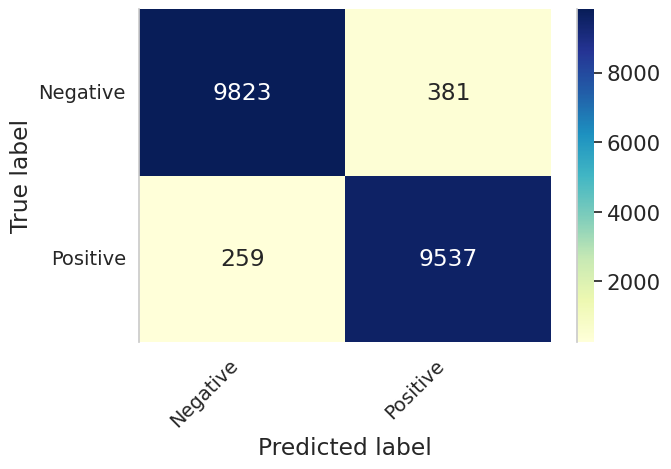

In [33]:
from utils import print_confusion_matrix
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_val, y_pred)

fig = print_confusion_matrix(
    conf_mx,
    class_names.values(),
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/bert/val_confusion_mx.png', dpi=200)

In [ ]:
## False positive / negative

In [34]:
false_pos = val_reviews[(y_val == 0) & (y_pred == 1)]
false_neg = val_reviews[(y_val == 1) & (y_pred == 0)]

In [35]:
pd.DataFrame(false_pos[:5])

,0
0,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable."
1,"Une bonne comédie qui ne dépasse guère le stade du catalogue de parodies et de l’humour burlesque. Pour peu que l’on adhère à ce type d’humour et que l’on en comprenne les références, on rigole franchement ; c’est hélas à peu près tout ce qu’apporte le film : une grosse déconne."
2,"Un film qui fait sourire, c'est en effet plus une comédie qu'un film d'action, le scénario est cohérent et original. Les acteurs ne sont pas mauvais avec un bravo à Jason Statham pour un rôle certes petit mais pas simple à jouer. Ce n'est pas un grand film mais on ne regrette pas de l'avoir vu."
3,"Intéressant et bien filmé, un docu qui a de l'impact!"
4,Un film d'importance pour son époque révélant les désastreuses cachotteries de l'industrie du nucléaire. Réalisation classique mais bien faite avec une bonne composition de Meryl Streep. Hélas le sujet aujourd'hui est bien dépassé et il faudrait vite sortir d'autres films sur les conséquences tragiques de ces projets industriels usant de nouvelles technologies qu'on lance les yeux fermés et nous conduisant souvent droit dans le mur...


In [36]:
pd.DataFrame(false_neg[:5])

,0
0,"Encore un film majeur tres mal distribué, comme par hasard... comme si on voulait nous empecher de comprendre comment on peut se faire gangrener par le mal. Est-ce que vous comprenez ? 4,5/5; cinematographiquement parlant."
1,"Intouchables n'est ni plus ni moins qu'une comédie basé sur des faits réels, le film ne mérite absolument pas son succès et Omar mérite absolument pas son césar car appart rire comme un con il ne sait pas jouer (attention je l'adore mais je sais reconnaître un mec talentueux) Cluzet lui est très talentueux et aurait mérité 100 fois le césar, sinon une sympathique comédie qui ne casse pas des briques, on s'amuse bien devant ce film."
2,"UN film muet réputé comme grandiose qui nem'a pas totalement convaincu, excepté la fin, assez magistrale. Ceci dit, on reconnait tout de même devant et derrière la caméra un homme assez magistral : Erich Von Stroheim. De son génie ressort une oeuvre particulièrement personnelle et tout de même très intéressante, notamment au niveau de la lumière. A vous de voir."
3,"Le film démarre un peu comme une comédie vacharde avec une tonalité sociale incarnée par la voix off de François Morel. La franchise des rapports sociaux fait vaguement penser au film la vie étalant fleuve tranquille. Anne le Ny ne va pas dans cette veine mais marque sa préférence pour des personnages bien barrés. Il y a quelques bonnes séquences bien comiques , À la fois d’une manière gestuelle et très traditionnelle française qui est la comédie à la Feydeau. La réalisatrice aime tordre le destin de ses personnages : j’aurais aimé qu’elle aille plus vers une critique sociale, façon Gone Girl de David Fincher."
4,"Encore du grand n'importe quoi et on aime ça ! Avant de découvrir le film,on se fait un retour en arriere des premiers ""épisodes"" de la saga ..ahha sacré Stifler! Mais le soucis est que la pression de ce 4e tant attendu,est lourde.Seront ils à la hauteur?Est ce que ce sera le retour qu'ils n'auraient pas du faire? Trop vieux pour ça peut être? Et la crédibilité dans tout ça! Après quelques minutes de film,force est de constater que le scénario est bien ""téléphoné"",prévisible.On voit apparaitre,un à un, les anciens de la série et les commentaires à voix haute arrivent"" qu'est ce qu'il a vieilli !"",""ah oui c'est vrai,je l'avais oublié!"",""hola, il est devenu vilain avec le temps,lui!"". Passé les ""retrouvailles"",on se dit :"" bon,on attend les premiers délires"",trame calculée,attendue,sans surprise..dommage mais inévitable. Puis les conneries déboulent à l’écran,s'enchainent.Certaines ,potaches ,d'autre plus fine.On rit,on retrouve finalement l'ambiance des ""American Pie"" d'avant.Certaine scènes sont bien ""caca-prout"" mais reste dans la veine de la saga,d'autre franchement crade et on n'a aucun mal à voir le spectre des gros bonnets du cinéma Hollywoodien qui attendent le retour sur investissements des gros cachets versés aux acteurs de la saga.Dommage que certains passages soient sur-joué,on ressent la pression du succès obligatoire...mais on rit en savourant le retour réussi de nos ""héros"" retrouvés."


In [38]:
model.load_weights('data/bert/camembert_weights.hdf5')

scores = model.predict(encoded_test)
y_pred = np.argmax(scores.logits, axis=1)

625/625 [==============================] - 21s 32ms/step


In [39]:
from sklearn import metrics

print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred,
    target_names=class_names.values()
)
print(report)

Test Accuracy: 96.92
Test F1-Score: 96.80

              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97     10408
    Positive       0.96      0.97      0.97      9592

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



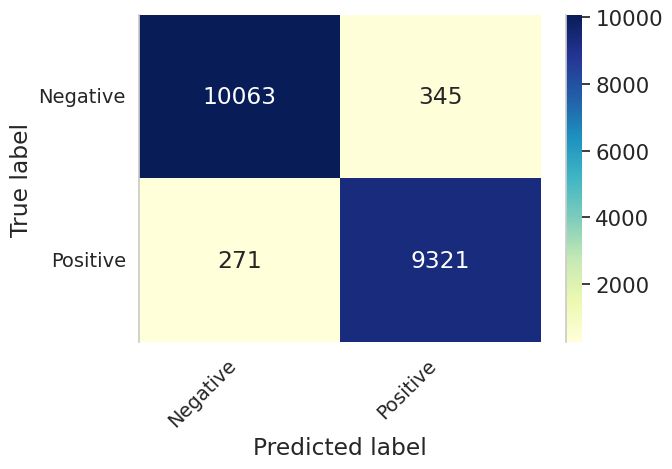

In [40]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx,
    class_names.values(),
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/bert/test_confusion_mx.png', dpi=200)